# Microsoft Stock Price Prediction: Introduction

Microsoft is one of the most successful technology companies, having products ranging from operating systems, mobile phones, laptops, tablets and more recently cloud services. Microsoft is a public company whose stock is traded on NASDAQ stock exchange. The price of Microsoft stock has witnessed a phenomenal increase in the last decade and is considered to be a 'Blue Chip' stock. In this notebook, we shall attempt to forecast the price of Microsoft's stock using time-series forecasting models such as LSTM, XGBoost and Facebook Prophet. 

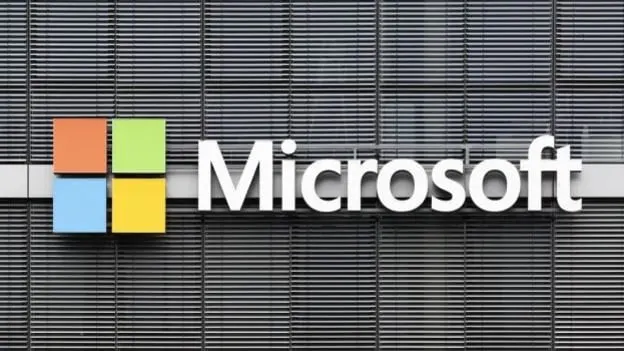

In [1]:
import numpy as np
from prophet import Prophet
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt

In [2]:
msft_stock_price = pd.read_csv('Microsoft_Stock.csv')

In [3]:
msft_stock_price.head()

Date   Open   High    Low  Close    Volume
0  4/1/2015 16:00:00  40.60  40.76  40.31  40.72  36865322
1  4/2/2015 16:00:00  40.66  40.74  40.12  40.29  37487476
2  4/6/2015 16:00:00  40.34  41.78  40.18  41.55  39223692
3  4/7/2015 16:00:00  41.61  41.91  41.31  41.53  28809375
4  4/8/2015 16:00:00  41.48  41.69  41.04  41.42  24753438

In [4]:
msft_stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


In [5]:
msft_stock_price.describe()

Open         High          Low        Close        Volume
count  1511.000000  1511.000000  1511.000000  1511.000000  1.511000e+03
mean    107.385976   108.437472   106.294533   107.422091  3.019863e+07
std      56.691333    57.382276    55.977155    56.702299  1.425266e+07
min      40.340000    40.740000    39.720000    40.290000  1.016120e+05
25%      57.860000    58.060000    57.420000    57.855000  2.136213e+07
50%      93.990000    95.100000    92.920000    93.860000  2.662962e+07
75%     139.440000   140.325000   137.825000   138.965000  3.431962e+07
max     245.030000   246.130000   242.920000   244.990000  1.352271e+08

In [6]:
msft_stock_price['Date'] = pd.to_datetime(msft_stock_price['Date'])
msft_stock_price = msft_stock_price.set_index('Date').asfreq('D')

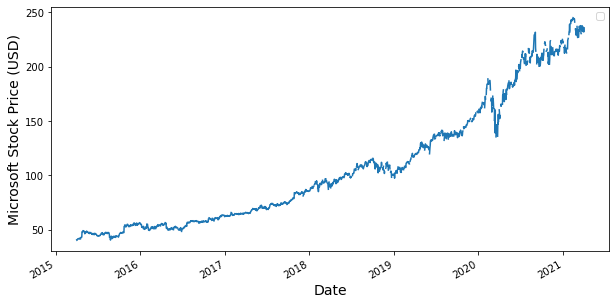

In [7]:
ax = msft_stock_price[['Close']].plot(figsize=(10,5))
ax.set_xlabel('Date', size=14)
ax.set_ylabel('Microsoft Stock Price (USD)', size=14)
ax.legend('')

In [8]:
msft_stock_price['Close'] = msft_stock_price['Close'].fillna(method='ffill')
msft_stock_price['Close'] = msft_stock_price['Close'].fillna(method='bfill')

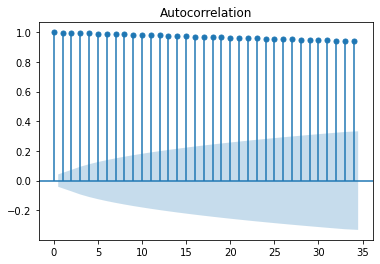

In [58]:
_ = plot_acf(msft_stock_price[['Close']])

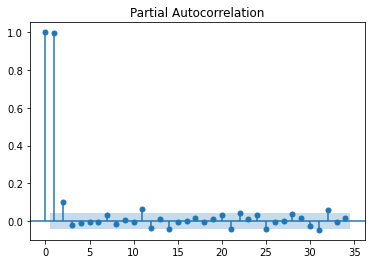

In [57]:
_ = plot_pacf(msft_stock_price['Close'])

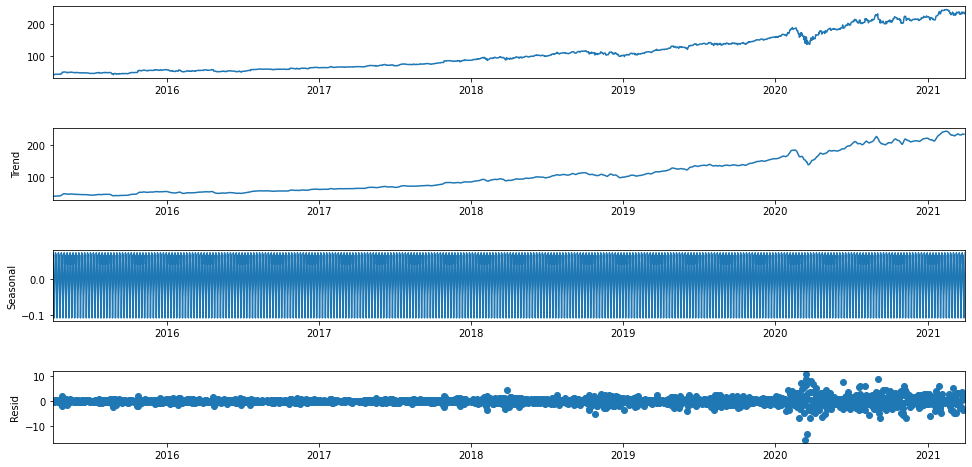

In [56]:
a = seasonal_decompose(msft_stock_price[['Close']], model = "additive")
ax = a.plot();
ax.set_figheight(7)
ax.set_figwidth(15)

Our goal will be to predict the stock price for 4 weeks in the future. Threfore, we shall split the data into train and test components where the test component will contain 20 working days (4 weeks) of data. All data predecding that will be part of the training set.

In [13]:
train_set = msft_stock_price[:-20]
test_set = msft_stock_price[-20:]

# Use Facbook Prophet model

In [14]:
# Facebook prophet requries input data to contain two columns, one datetime column (ds) and the other column 
# contianing the variable being predicted (y).

train_set_fbp = train_set.reset_index()
train_set_fbp = train_set_fbp.rename(columns={'Date': 'ds', 'Close': 'y'})

test_set_fbp = test_set.reset_index()
test_set_fbp = test_set_fbp.rename(columns={'Date': 'ds', 'Close': 'y'})

In [15]:
m = Prophet()
m.fit(train_set_fbp[['ds','y']])

06:28:20 - cmdstanpy - INFO - Chain [1] start processing
06:28:21 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
forecast = m.predict(test_set_fbp[['ds']])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
15 2021-03-27 16:00:00  235.168453  229.165182  241.038882
16 2021-03-28 16:00:00  235.396901  229.017187  241.486798
17 2021-03-29 16:00:00  235.787835  229.514545  241.835287
18 2021-03-30 16:00:00  236.160865  230.302083  242.546448
19 2021-03-31 16:00:00  236.627825  230.924999  242.641722

In [17]:
predictions = pd.merge(forecast, test_set_fbp[['ds','y']], on='ds')

Text(0, 0.5, 'MSFT Price (USD)')

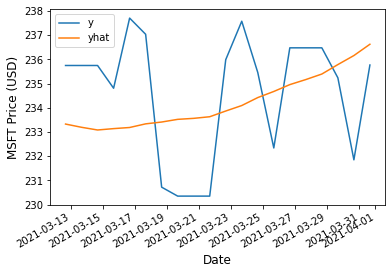

In [18]:
ax = predictions[['y', 'yhat', 'ds']].plot(x='ds')
ax.set_xlabel('Date', size=12)
ax.set_ylabel('MSFT Price (USD)', size=12)

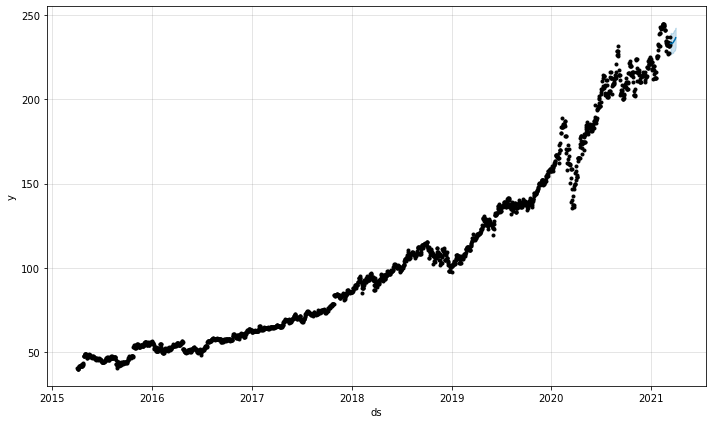

In [19]:
fig1 = m.plot(forecast)

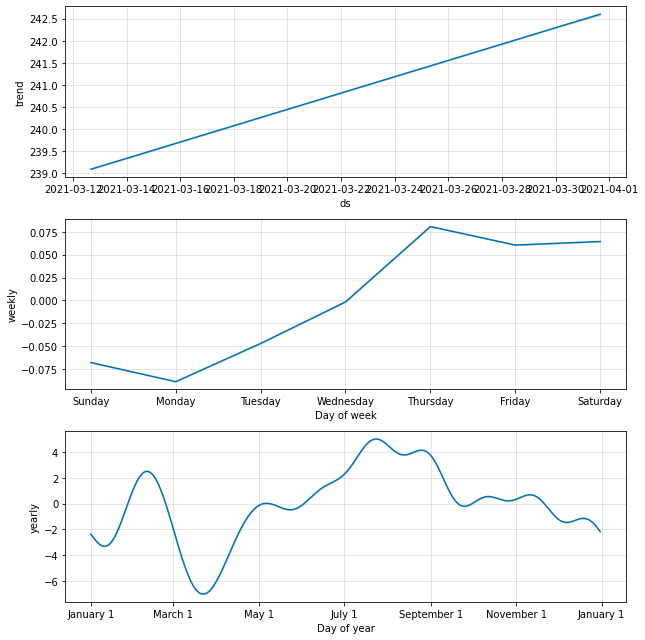

In [20]:
fig2 = m.plot_components(forecast)

In [21]:
from sklearn.metrics import *

In [60]:
RMSE_fbp = mean_squared_error(predictions['y'], predictions['yhat'])**(0.5)
print(RMSE_fbp)

2.6729877883047597


In [61]:
MAPE_fbp = mean_absolute_percentage_error(predictions['y'], predictions['yhat'])
print(MAPE_fbp)

0.010353421186981498


# Can we use other time-series models to predict the stock price?

Let's try to make predictions of Bitocin's price using the LSTM model. LSTM is a recurrent neural network (RNN) architecture that “remembers” values at arbitrary intervals. LSTM is well suited for classifying, processing and predicting time series with time intervals of unknown duration.

In [27]:
# Import the necessary libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [28]:
# Define functions used for processing input data and creating model

# Normalizes the data
def to_dataset(data):
    data = data.astype('float32')
    scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(data), scaler

# Data train and test
def train_test(data):
    train_size = int(len(data) - 40)
    train, test = data[0:train_size, :], data[train_size:len(data), :]
    return train, test
# 
# Time windows - use 10 days to forecast the next 10 days 
def windows(sequence, step_in, step_out):
    x, y = [], []
    for i in range(len(sequence)):
        end_i = i + step_in
        out_i = end_i + step_out
        if out_i > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_i, :], sequence[end_i:out_i, :]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Build a stacked LSTM model
def create_model(step_in, step_out, features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(step_in, features)))
    model.add(RepeatVector(step_out))
    model.add(Dropout(0.2))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(features)))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# Run all functions
def prepare_training(data, step_in, step_out):
    data, scaler = to_dataset(data)
    train, test = train_test(data)
    x_train, x_test = windows(train, step_in, step_out)
    y_train, y_test = windows(test, step_in, step_out)
    features = 1
    return x_train, x_test, y_train, y_test, features, scaler

In [29]:
step_in, step_out = 20, 20 
epochs = 50 

early = EarlyStopping(monitor='val_loss',patience=5)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

In [30]:
data = msft_stock_price['Close'].values
data = data.reshape(-1, 1)

In [31]:
x_train, y_train, x_test, y_test, feature, scaler = prepare_training(data, step_in, step_out)

In [32]:
model = create_model(step_in, step_out, feature)

In [33]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=144, verbose=1,
         validation_data=(x_test, y_test), callbacks=[early,reduce])

Epoch 1/50
15/15 [==============================] - 3s 72ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - val_loss: 0.1638 - val_mean_squared_error: 0.1638 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 1s 52ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0776 - val_mean_squared_error: 0.0776 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - 1s 52ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 1s 56ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - 1s 58ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - 1s 55ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0044 - 

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 repeat_vector (RepeatVector  (None, 20, 50)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 200)           200800    
                                                                 
 time_distributed (TimeDistr  (None, 20, 1)            201       
 ibuted)                                                         
                                                                 
Total params: 211,401
Trainable params: 211,401
Non-trai

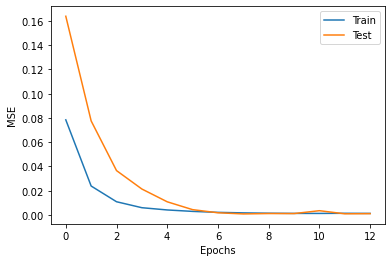

In [35]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Test']);

In [36]:
pred = model.predict(x_test)

1/1 [==============================] - 0s 207ms/step


In [37]:
y_actual = scaler.inverse_transform(y_test[0])
y_pred = scaler.inverse_transform(pred[0])

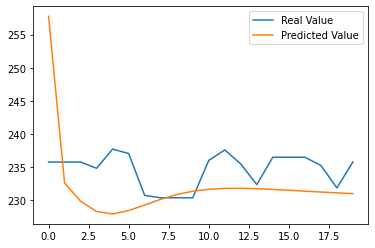

In [40]:
plt.plot(y_actual)
plt.plot(y_pred)
plt.legend(['Real Value','Predicted Value']);

In [63]:
RMSE_lstm = mean_squared_error(test_set['Close'], y_pred)**0.5
print(RMSE_lstm)

6.8097525038844156


In [62]:
MAPE_lstm = mean_absolute_percentage_error(test_set['Close'], y_pred)
print(MAPE_lstm)

0.02081057144572445


# Use XGBoost Model

Let's try to make predictions of Bitocin's price using the XGBoost model. XGBoost is a powerful supervised learnign algorithm which has been used in time-series forecasting as well as in many other regression and classification tasks. It regularly appears in work produced by Kaggle competition high scorers. 

We must first convert the time series model to a supervised learning problem by extracting date, time and seasonality features from the date column.

In [42]:
def add_date_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [43]:
%%capture --no-display

# Use the same train and test data sets as in the above example
X_train_xgboost, y_train_xgboost = add_date_features(train_set, label='Close')
X_test_xgboost, y_test_xgboost = add_date_features(test_set, label='Close')

In [44]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model_xgboost =  xgb.XGBRegressor(objective ='reg:linear', booster='gbtree', colsample_bytree = 0.3, 
                          learning_rate = 0.1, n_estimators = 1000)
model_xgboost.fit(X_train_xgboost, y_train_xgboost,
        eval_set=[(X_train_xgboost, y_train_xgboost), (X_test_xgboost, y_test_xgboost)],
        early_stopping_rounds=100,
       verbose=False) # Change verbose to True if you want to see it train

C:\Users\aq_po\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[06:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [45]:
ypred = model_xgboost.predict(X_test_xgboost)

In [46]:
test_set['ypred'] = ypred

C:\Users\aq_po\AppData\Local\Temp/ipykernel_23248/3659920691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['ypred'] = ypred


<AxesSubplot:xlabel='Date'>

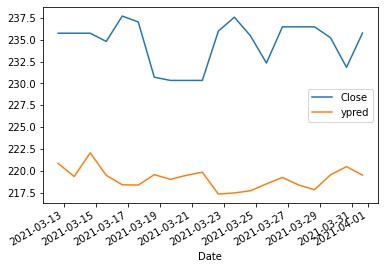

In [47]:
test_set[['Close','ypred']].plot()

In [48]:
test_set['y_pred_lstm'] = y_pred

C:\Users\aq_po\AppData\Local\Temp/ipykernel_23248/1607811366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['y_pred_lstm'] = y_pred


Text(0.5, 1.0, 'BTC Price Forecast using multiple time-series models')

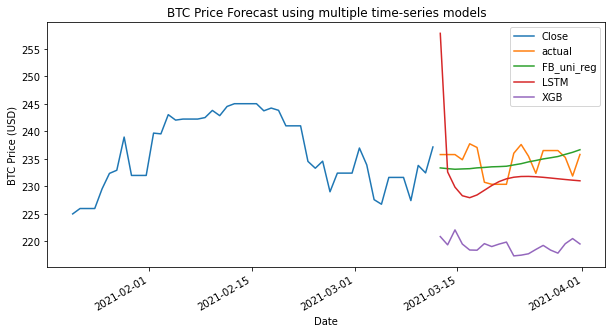

In [49]:
ax = train_set.iloc[-50:].plot(y='Close', figsize=(10,5))
test_set.plot(y='Close', ax=ax, label='actual')
predictions.plot(x='ds', y='yhat', ax=ax, label='FB_uni_reg')
test_set.plot(y='y_pred_lstm', ax=ax, label='LSTM')
test_set.plot(y='ypred', ax=ax, label='XGB')
ax.set_xlabel('Date')
ax.set_ylabel('BTC Price (USD)')
ax.set_title('BTC Price Forecast using multiple time-series models')

In [64]:
RMSE_xgboost = mean_squared_error(test_set['Close'], test_set['ypred'])**0.5
print(RMSE_xgboost)

15.781808117116672


In [65]:
MAPE_xgboost = mean_absolute_percentage_error(test_set['Close'], test_set['ypred'])
print(MAPE_xgboost)

0.06586197725627367


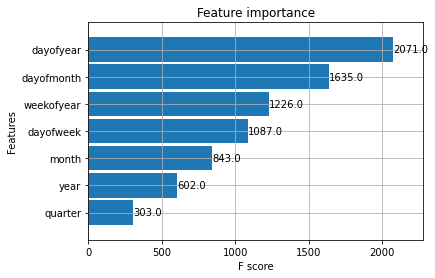

In [66]:
_ = plot_importance(model_xgboost, height=0.9)

<AxesSubplot:>

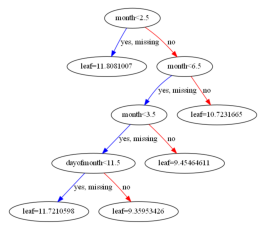

In [67]:
plot_tree(model_xgboost)

In [70]:
RMSEs = [RMSE_fbp, RMSE_lstm, RMSE_xgboost]
MAPEs = [MAPE_fbp, MAPE_lstm, MAPE_xgboost]

Text(0, 0.5, 'RMSE')

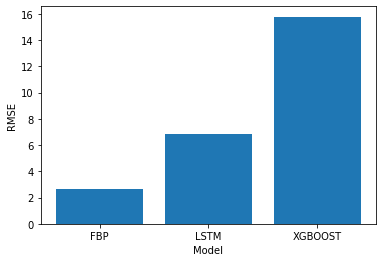

In [69]:
ax = plt.bar(['FBP', 'LSTM', 'XGBOOST'], height=RMSEs)
plt.xlabel('Model')
plt.ylabel('RMSE')

In this analysis we found the Facebook Prophet model to perform the best in terms of having the lowest RMSE , followed by LSTM, while XGBoost had the lowest scores. The work presented here is a preliminary analysis and is not by any means a definitive evaluation of the merits of prediction by any of the models. There are several ways these models could be improved, which include:

- hyperparameter tuning
- addition of relevant regressors based on consultations with subject area experts (SMEs)
- adding features such as days in which earnings reports were announced and big conference days inwhich annoucements are expected
- adding regularisation to prevent overfitting in the train set.